## TP11: Gaussian Variational Bayes

**Alumna**: Lucia Berard

**Fecha**: 22/06/2025

**[Link a Google Colab](https://colab.research.google.com/drive/10q25-JtuRTZ_2s3T98p4wq0pxxXPohj_?usp=sharing)**


Se desea modelar el tiempo (en minutos con respecto a la hora de entrada) en que diferentes grupos de estudiantes llegan a una determinada clase de la facultad. Estos comportamientos serán modelados como una mezcla de 6 comportamientos distintos dentro de las rutinas de las personas.


> **IMPORTANTE**: En este ejercicio solamente se podrá importar numpy, matplotlib.pyplot y las funciones gamma, digamma y softmax de scipy.special (el resto deberá ser implementación propia).

In [1]:
# Librerias permitidas
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, digamma, softmax

np.random.seed(42)


_____
## (a) Creación del dataset:


> Generar 100 muestras de una mezcla de gaussianas con pesos 0.1, 0.4, 0.2, 0.3, medias −4, 0, 4, 5 y varianzas 1, 1.96, 1.44, 1 respectivamente. *Interpretación*: En realidad existían 4 comportamientos marcados (aunque nosotros no lo sabíamos).
> Ellos pueden pensarse como:
>
> • Un 10 % de personas muy puntuales (μ = −4 y varianza más pequeña).
>
> • Un 40 % de personas que tienden a llegar justo (μ = 0).
>
> • Un 20 % de personas "relajadas" (μ = 4).
>
> • Un 30 % de personas consistentemente impuntuales (μ = 5 y varianza más pequeña).


Queremos simular una una mezcla de gaussianas, lo que significa que cada muestra $x_i$ no proviene de una sola normal, sino que:
- Se elige primero una de las 4 normales con cierta probabilidad (peso).
- Luego se genera un valor a partir de esa normal (media y varianza específicas).
- Esto simula comportamientos distintos (puntuales, justos, relajados, impuntuales), cada uno modelado con una Gaussiana.

La función matemática de una mezcla de gaussianas es:

$$
p(x) = \sum_{k=1}^{K} \pi_k \cdot \text{N}(x \mid \mu_k, \sigma_k^2)
$$

Donde:
- K = 4: cantidad de componentes
- $\pi_k$: pesos (suman 1)
- $\mu_k$: medias
- $\sigma_k^2$: varianzas
- El símbolo $\text{N}$ es una notación abreviada para referirse a la distribución normal (o gaussiana)


(Definicion de la bibliografia de Gupta, en la sección 3.2 Learning a GMM)

**Parametros del enunciado:**


| Comportamiento | Media ($\mu$) | Varianza ($\sigma^2$) | Peso ($\pi$) |
| -------------- | ------------- | --------------------- | ------------ |
| Muy puntuales  | −4            | 1                     | 0.1          |
| Llegan justo   | 0             | 1.96                  | 0.4          |
| Relajados      | 4             | 1.44                  | 0.2          |
| Impuntuales    | 5             | 1                     | 0.3          |



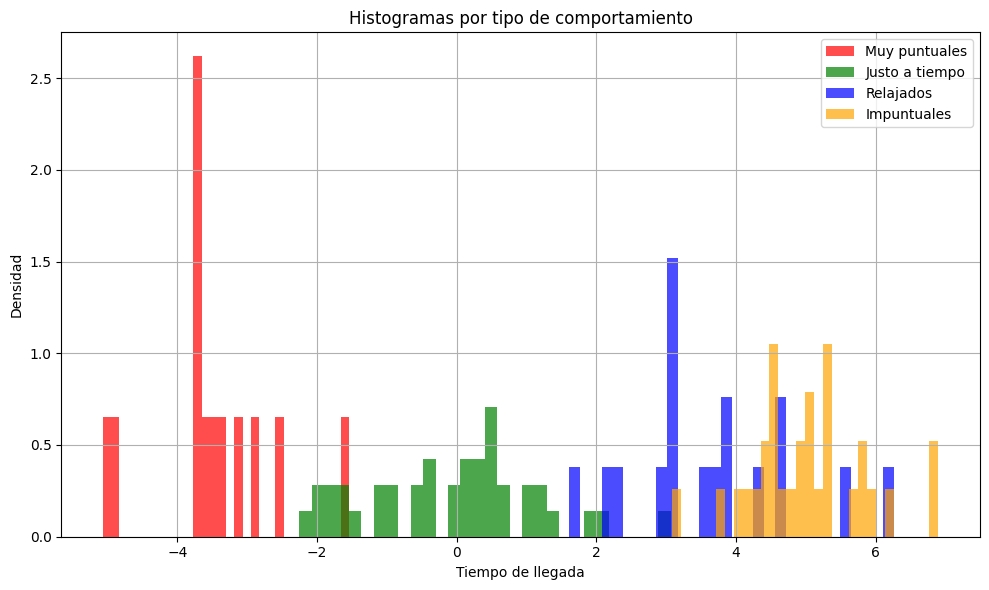

In [2]:
# Parámetros
pesos = [0.1, 0.4, 0.2, 0.3]
medias = [-4, 0, 4, 5]
varianzas = [1, 1.96, 1.44, 1]
desvios = np.sqrt(varianzas)
N = 100

# Etiquetas para cada comportamiento
labels = ["Muy puntuales", "Justo a tiempo", "Relajados", "Impuntuales"]

# Selección de componentes según pesos
componentes = np.random.choice(len(pesos), size=N, p=pesos)

# Generación de datos según el componente
X = np.array([np.random.normal(loc=medias[c], scale=desvios[c]) for c in componentes])

# Agrupar los datos por componente
colores = ['red', 'green', 'blue', 'orange']

# P histogramas por tipo
fig1, ax1 = plt.subplots(figsize=(10, 6))
for k in range(4):
    datos_k = X[componentes == k]
    ax1.hist(datos_k, bins=30, density=True, alpha=0.7, color=colores[k], label=labels[k])

ax1.set_title("Histogramas por tipo de comportamiento")
ax1.set_xlabel("Tiempo de llegada")
ax1.set_ylabel("Densidad")
ax1.grid(True)
ax1.legend()
plt.tight_layout()
plt.show()



____
## (b) K-means:

> - Implementar un algoritmo de K-means para caracterizar la puntualidad de los estudiantes. El entrenamiento debe contener doble condición de parada (número de iteraciones y convergencia). El algoritmo debe ser definido dentro de una clase que posea al menos los métodos <code>init</code>, <code>fit</code> y <code>predict</code>.
>
> - Modelar una mezcla de gaussianas con los resultados del entrenamiento. 🔀: Las medias sean los centroides, las varianzas sean estimadas intra-clase y los pesos sean la proporción de las muestras.
>
> - Graficar la densidad estimada y compararla con la original.


La idea de este ítem es realizar el "camino inverso" de lo generado en el ítem (a). Mientras que en el ítem (a) se simuló una mezcla de gaussianas para generar los datos, aca se parte de esos datos (sin conocer las etiquetas verdaderas) y se aplica K-means para identificar posibles grupos o patrones.

Luego, se puede reinterpretar el resultado como una mezcla de gaussianas:

- Cada cluster se asume como una gaussiana.
- Las medias $𝜇_k$ corresponden a los centroides.
- Las varianzas $𝜎_k^2$ se estiman dentro de cada cluster.
- Los pesos $𝜋_k$ se calculan como la proporción de muestras en cada cluster.

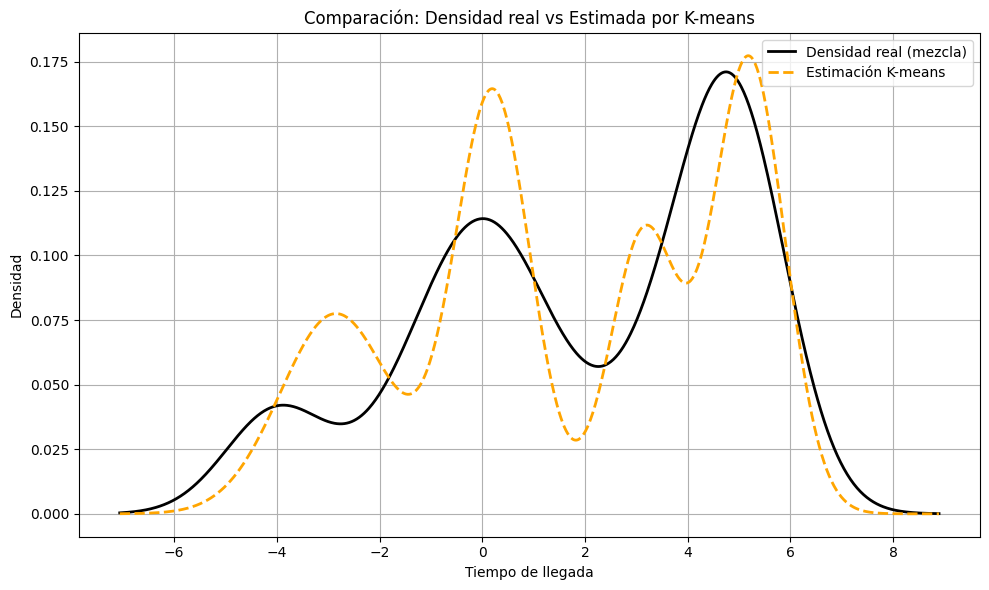

In [3]:
# IMPLEMENTACIÓN K-means
np.random.seed(42) # para que los resultados sean siempre los mismos
class KMeans:
    def __init__(self, k=4, max_iter=100, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        X = np.array(X)
        self.centroids = np.random.choice(X, self.k, replace=False)
        # Condición de parada 1: se itera hasta un máximo de 'max_iter'
        for i in range(self.max_iter):
            # Asignación de clusters
            self.labels_ = np.array([np.argmin(np.abs(x - self.centroids)) for x in X])
            # Recalcular centroides
            new_centroids = np.array([
                X[self.labels_ == j].mean() if np.any(self.labels_ == j) else self.centroids[j]
                for j in range(self.k)
            ])
            # Condición de parada 2: se detiene si los centroides convergen (cambian menos que 'tol')
            if np.linalg.norm(self.centroids - new_centroids) < self.tol:
                break
            self.centroids = new_centroids

    def predict(self, X):
        return np.array([np.argmin(np.abs(x - self.centroids)) for x in X])

# Función de densidad de una gaussiana (implementacion propia porque no puedo usar norm)
# Bishop, p. 87
def gaussian_pdf(x, mu, sigma):
    return (1.0 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Entrenar el modelo K-means con k=4
kmeans = KMeans(k=4)
kmeans.fit(X)
labels_pred = kmeans.predict(X)

# MODELADO DE MEZCLA DE GAUSSIANAS A PARTIR DEL RESULTADO DE K-means
# Medias: los centroides de K-means
mus_kmeans = kmeans.centroids
# Varianzas intra-clase: desviaciones estándar dentro de cada cluster
sigmas_kmeans = np.array([np.std(X[labels_pred == i]) for i in range(4)])
# Pesos: proporción de muestras en cada cluster
pesos_kmeans = np.array([np.mean(labels_pred == i) for i in range(4)])

# GRAFICAR LA DENSIDAD ESTIMADA Y COMPARARLA CON LA ORIGINAL
x_vals = np.linspace(min(X) - 2, max(X) + 2, 1000)

# Funcion para calcular la densidad
def obtener_densidad(x, mus, sigmas, pesos):
    return sum(pesos[i] * gaussian_pdf(x, mus[i], sigmas[i]) for i in range(len(mus)))

# Densidad estimada (mezcla a partir de K-means)
densidad_kmeans = obtener_densidad(x_vals, mus_kmeans, sigmas_kmeans, pesos_kmeans)
# Densidad real (usada al generar los datos)
densidad_real = obtener_densidad(x_vals, medias, desvios, pesos)

# Graficar ambas densidades
plt.figure(figsize=(10, 6))
plt.plot(x_vals, densidad_real, label="Densidad real (mezcla)", color='black', linewidth=2)
plt.plot(x_vals, densidad_kmeans, label="Estimación K-means", color='orange', linewidth=2, linestyle='--')
plt.title("Comparación: Densidad real vs Estimada por K-means")
plt.xlabel("Tiempo de llegada")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**¿Qué significa este gráfico?**

Ambas líneas siguen la misma forma general, lo cual es muy bueno: quiere decir que el K-means pudo recuperar una buena aproximación de los comportamientos originales a pesar de no tener acceso a las etiquetas verdaderas.

Sin embargo, como K-means no considera la varianza de los datos al formar los grupos, presenta limitaciones en zonas donde las distribuciones se superponen. En estos casos, tiende a separar por el medio, generando cortes artificiales o picos dobles en regiones que deberían modelarse con una sola componente más ancha.

En resumen, K-means es útil como una primera aproximación no probabilística, pero no modela la incertidumbre ni el solapamiento entre componentes

____
## (c) Expectation-Maximization:

> • Implementar un algoritmo de EM para caracterizar la puntualidad de los estudiantes. Inicializar el algoritmo con el modelo de K-means. El entrenamiento debe contener doble condición de parada (número de iteraciones y convergencia). El algoritmo EM debe ser definido dentro de una clase que posea al menos los métodos `init`, `fit`, `predict_proba` y `predict`.
>
> • Graficar la densidad estimada, compararla con la de K-means y con la original.

El algoritmo **EM** se utiliza para ajustar modelos de mezcla de gaussianas (GMMs) cuando las etiquetas verdaderas son desconocidas. Dado que no sabemos qué componente generó cada dato \( x_n \), usamos EM para estimar esa información latente y los parámetros del modelo.

EM alterna entre:

- **E-step (Expectation)**: estima lo que no vemos .

- **M-step (Maximization)**: actualiza los parámetros $\mu_k, \sigma_k^2, \pi_k $.

#### **E-step: cálculo de responsabilidades $ \gamma_{nk}$**

Las **responsabilidades** en este caso son las probabilidades de que el punto $x_n$ haya sido generado por la componente $k$:

$$
\gamma_{nk} = \frac{\pi_k \cdot \text{N}(x_n \mid \mu_k, \sigma_k^2)}{\sum_{j=1}^K \pi_j \cdot \text{N}(x_n \mid \mu_j, \sigma_j^2)}
$$

Este paso realiza un **soft-clustering**: cada punto puede pertenecer parcialmente a varios clusters.


#### **M-step: actualización de parámetros**

Dado el valor actual de las responsabilidades, se actualizan los parámetros del modelo:

- Peso efectivo de cada componente:
$
N_k = \sum_{n=1}^N \gamma_{nk}
$

- Media:
$
\mu_k = \frac{1}{N_k} \sum_{n=1}^N \gamma_{nk} x_n
$

- Varianza:
$
\sigma_k^2 = \frac{1}{N_k} \sum_{n=1}^N \gamma_{nk} (x_n - \mu_k)^2
$

- Peso de mezcla:
$
\pi_k = \frac{N_k}{N}
$




Referencias:
- **Bishop**, *Pattern Recognition and Machine Learning*, Cap. 9.3.1 (p. 431–435)
- **Gupta**, Capítulo 4.4 y 4.5, "Inference in Gaussian Mixture Models"
- **Notas de Andrew Ng**, sección "EM Algorithm for Gaussian Mixtures"



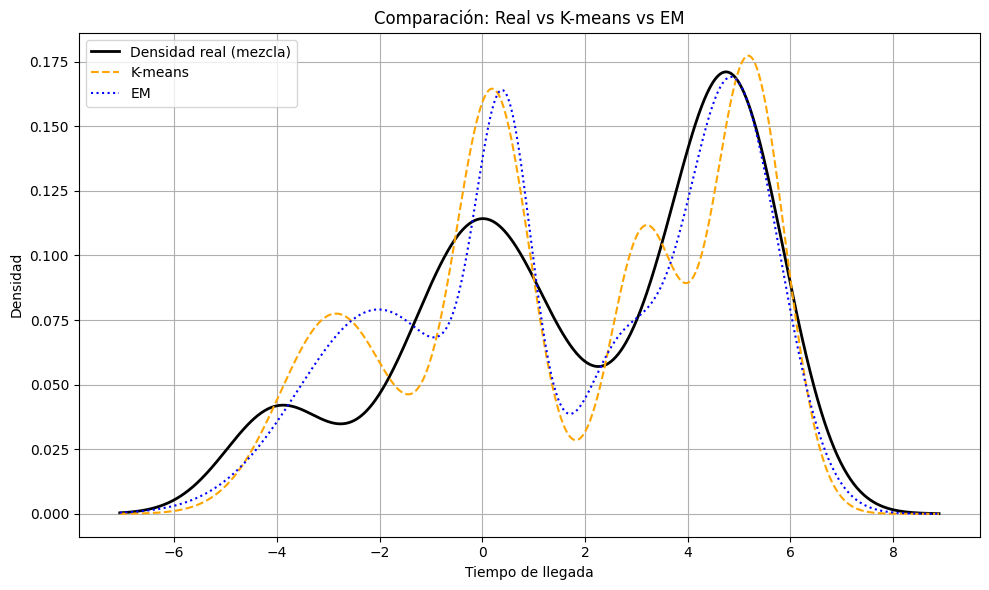

In [4]:
class GaussianMixtureEM:
    def __init__(self, k=4, max_iter=100, tol=1e-4):
        self.k = k # numero de componentes gaussianas
        self.max_iter = max_iter #tope maximo de iteraciones
        self.tol = tol #tolerancia para la convergencia en las medias

    def fit(self, X, mus_init=None, sigmas_init=None, pesos_init=None, labels=None):
        X = np.array(X)
        N = len(X)

        # Inicializacion automatica desde etiquetas de Kmeans
        if labels is not None:
            self.mus = np.array([X[labels == i].mean() for i in range(self.k)])
            self.sigmas = np.array([np.std(X[labels == i]) for i in range(self.k)])
            self.pesos = np.array([np.mean(labels == i) for i in range(self.k)])
        # Inicialización manual: pasar los parametros iniciales
        elif mus_init is not None and sigmas_init is not None and pesos_init is not None:
            self.mus = mus_init.copy()
            self.sigmas = sigmas_init.copy()
            self.pesos = pesos_init.copy()
        else:
            raise ValueError("Debes pasar labels o (mus_init, sigmas_init, pesos_init)")

        # Condición de parada 1: máximo de iteraciones
        for it in range(self.max_iter):
            # E-step:
            gammas = np.zeros((N, self.k))
            for k in range(self.k):
                gammas[:, k] = self.pesos[k] * gaussian_pdf(X, self.mus[k], self.sigmas[k])
            gammas /= np.sum(gammas, axis=1, keepdims=True)
            Nks = np.sum(gammas, axis=0)

            # M-step
            new_mus = np.sum(gammas * X[:, None], axis=0) / Nks
            new_sigmas = np.sqrt(np.sum(gammas * (X[:, None] - new_mus)**2, axis=0) / Nks)
            new_pesos = Nks / N

            # Condición de parada 2: convergencia en las medias
            if np.linalg.norm(self.mus - new_mus) < self.tol:
                break

            self.mus, self.sigmas, self.pesos = new_mus, new_sigmas, new_pesos

    def predict_proba(self, X):
        X = np.array(X)
        gammas = np.zeros((len(X), self.k))
        for k in range(self.k):
            gammas[:, k] = self.pesos[k] * gaussian_pdf(X, self.mus[k], self.sigmas[k])
        gammas /= np.sum(gammas, axis=1, keepdims=True)
        return gammas

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

em = GaussianMixtureEM(k=4)
em.fit(X, labels=labels_pred)

# Densidad estimada por EM
densidad_em = sum(em.pesos[i] * gaussian_pdf(x_vals, em.mus[i], em.sigmas[i]) for i in range(4))

plt.figure(figsize=(10, 6))
plt.plot(x_vals, densidad_real, label="Densidad real (mezcla)", color='black', linewidth=2)
plt.plot(x_vals, densidad_kmeans, label="K-means", color='orange', linestyle='--')
plt.plot(x_vals, densidad_em, label="EM", color='blue', linestyle=':')
plt.title("Comparación: Real vs K-means vs EM")
plt.xlabel("Tiempo de llegada")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Se puede ver que EM hace un mejor trabajo estimando la densidad real comparado con K-means. Esto pasa porque EM no se queda con una única asignación de cada punto a un cluster, sino que calcula probabilidades de pertenencia (las llamadas "responsabilidades") y va ajustando las medias, varianzas y pesos de cada componente de forma iterativa.

Como además lo arrancamos con los resultados de K-means, ya parte de una base razonable y eso le permite mejorar sin perder tiempo explorando asignaciones malas.

Un ejemplo claro está alrededor de $x≈3$, donde K-means mete dos picos que no deberían estar. EM en cambio los corrige y ajusta mejor la forma de la densidad. Esto se debe a que K-means no tiene en cuenta la varianza: divide por distancia, aunque no sea lo más natural para los datos.

____
## (d) Gaussian Variational Bayes:

> • Implementar un Variational Bayes Gaussiano que permita computar el modelo. Suponer *a priori* m = 0, δ = ν = β = 0.05 y α = (1, 1, 1, 1, 1, 1), y utilizar el algoritmo EM para inicializar las probabilidades. El entrenamiento debe contener doble condición de parada (número de iteraciones y convergencia). El algoritmo debe ser definido dentro de una clase que posea al menos los métodos `init`, `fit`, `predict_proba` y `predict`.
>
> • Con la distribución *a posteriori* generar 3 muestras de parámetros y graficar la densidad de X|μ, λ, π para cada uno de esos conjuntos de parámetros. Compararla con la densidad verdadera, con la de K-means y con la del EM.
>
> • Graficar la densidad *predictiva*. Compararla con la densidad verdadera, con la de K-means y con la del EM.


A diferencia del EM tradicional, que busca parámetros puntuales $(\mu_k, \lambda_k, \pi_k)$, el enfoque Variational Bayes (VB) estima **distribuciones a posteriori** sobre estos parámetros. Se aproxima la verdadera distribución posterior $p(\theta, Z \mid X)$:

$$
q(Z, \pi, \mu, \lambda) = q(Z) \cdot q(\pi) \cdot \prod_{k=1}^K q(\mu_k, \lambda_k)
$$

Los valores a priori fueron fijados por el enunciado:

- Media previa: $m_0 = 0$
- Precisión de la media: $\beta_0 = 0.05 $
- Grados de libertad: $\nu_0 = 0.05 $
- Parámetro de escala: $ W_0 = 0.05 $
- Pesos de mezcla: $\pi \sim \text{Dirichlet}(\alpha_0 = [1, 1, ..., 1]) $

E-Step:

$$
\ln r_{nk} \propto \mathbb{E}[\ln \pi_k] + \frac{1}{2} \mathbb{E}[\ln \lambda_k] - \frac{1}{2} \left( \frac{1}{\beta_k} + \nu_k (x_n - m_k)^2 \right) \mathbb{E}[\lambda_k] - \frac{1}{2} \ln(2\pi)
$$
Esto define la distribución de pertenencia del punto $x_n$ al cluster $k$.

M-step:

Con los nuevos $ r_{nk} $ se actualizan:

- $ N_k = \sum_n r_{nk} $
- $ \alpha_k = \alpha_0 + N_k $
- $ \beta_k = \beta_0 + N_k $
- $ m_k = \frac{\beta_0 m_0 + \sum_n r_{nk} x_n}{\beta_k} $
- $ \nu_k = \nu_0 + N_k $
- $ W_k = \left[ \frac{1}{W_0} + \sum_n r_{nk} x_n^2 + \beta_0 m_0^2 - \beta_k m_k^2 \right]^{-1} $

La convergencia se verifica por el cambio en las medias $ m_k $.

Densidad Predictiva:

La densidad predictiva se aproxima integrando sobre los parámetros bajo su distribución variacional:

$$
p(x \mid X) \approx \sum_k \frac{\alpha_k}{\sum_j \alpha_j} \cdot \text{N}\left(x \mid m_k, \left( \nu_k W_k \right)^{-1} + \beta_k^{-1} \right)
$$

Referencias:
- Bishop, "Pattern Recognition and Machine Learning", Capítulo 10.2.2 (p. 470–475)
- Gupta, Capítulos 4.7 y 4.8
- Andrew Ng Notes, sección "Variational Inference for GMMs"



Muestra 1, densidad máx: 0.1401
Muestra 2, densidad máx: 0.1384
Muestra 3, densidad máx: 0.1320


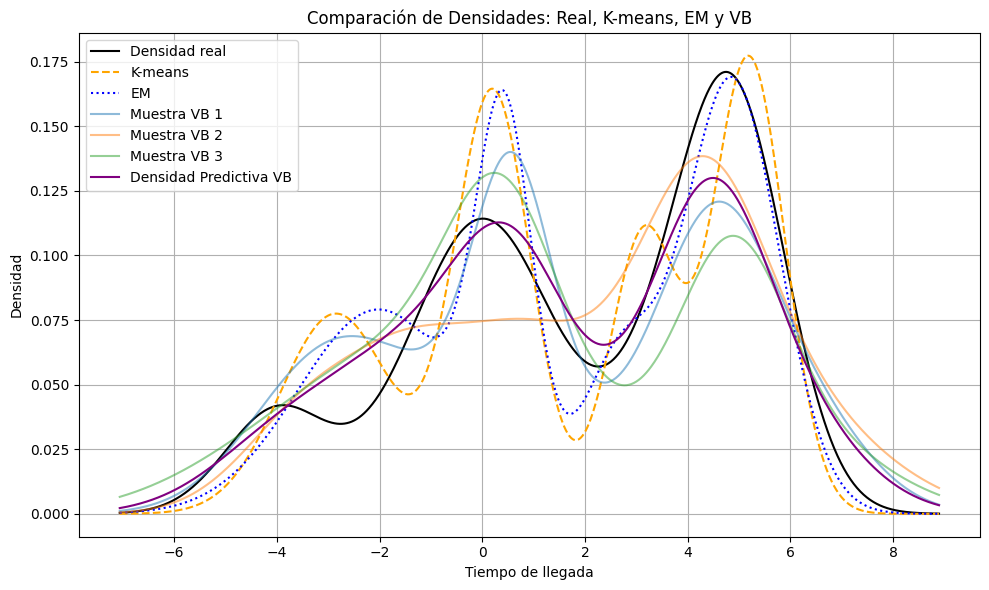

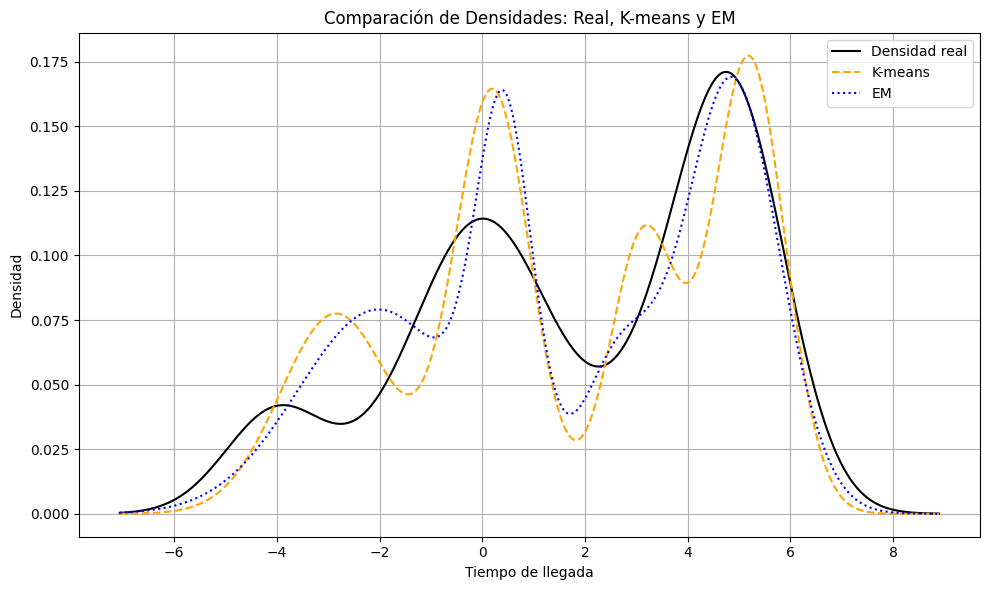

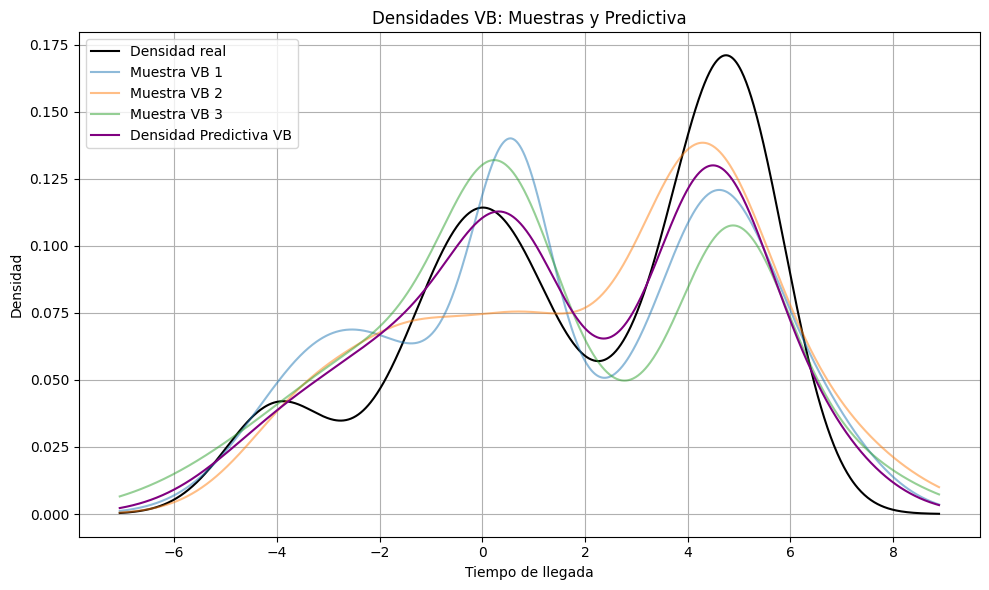

In [5]:
# REENTRENAR CON K = 6
np.random.seed(42)
kmeans_6 = KMeans(k=6)
kmeans_6.fit(X)
labels_pred_6 = kmeans_6.predict(X)

em = GaussianMixtureEM(k=6)
em.fit(X, labels=labels_pred_6)
r_init = em.predict_proba(X)

# DEFINICION DE LA CLASE VB
class VariationalBayesGMM:
    def __init__(self, k=6, max_iter=100, tol=1e-4):
        self.k = k # cantidad de componentes gaussianas
        self.max_iter = max_iter # maximo de iteraciones para el entrenamiento
        self.tol = tol #tolerancia para criterio de convergencia

        # Priors fijos: controlan la flexibilidad y suavizado del modelo
        self.m_0 = 0  # media previa
        # precicion de la media y del lamdba
        self.beta_0 = 0.05
        self.nu_0 = 0.05
        self.alpha_0 = np.ones(k) # dirichlet uniforme sobre los pesos de mezcla

    def fit(self, X, r_init):
      # "corazon del algoritmo": ajusta parametros a posteriori a partir de los datos de X
      # y las responsabilidades iniciales r_{nk} que son las probabilidades de pertenencia a cada cluster (viene de EM)
        X = np.array(X)
        N = len(X)

        r = r_init
        Nk = r.sum(axis=0)

        # Inicialización posterior
        self.alpha = self.alpha_0 + Nk
        self.beta = self.beta_0 + Nk
        self.m = (self.beta_0 * self.m_0 + np.dot(r.T, X)) / self.beta
        self.nu = self.nu_0 + Nk

        x_square = X**2
        E_x2 = np.dot(r.T, x_square)
        self.W = 1 / (1 / 0.05 + E_x2 + self.beta_0 * self.m_0**2 - self.beta * self.m**2)

        for i in range(self.max_iter):
            # E-step
            E_ln_pi = digamma(self.alpha) - digamma(np.sum(self.alpha))
            E_ln_lambda = digamma(self.nu / 2) - np.log(1 / self.W)
            E_lambda = self.nu / self.W

            ln_rho = np.zeros((N, self.k))
            for k in range(self.k):
                diff = X - self.m[k]
                ln_rho[:, k] = (
                    E_ln_pi[k]
                    + 0.5 * E_ln_lambda[k]
                    - 0.5 * (1 / self.beta[k] + self.nu[k] * diff**2) * E_lambda[k]
                    - 0.5 * np.log(2 * np.pi)
                )

            ln_r = ln_rho - ln_rho.max(axis=1, keepdims=True)
            r = np.exp(ln_r)
            r /= r.sum(axis=1, keepdims=True)

            Nk_new = r.sum(axis=0)
            m_new = (self.beta_0 * self.m_0 + np.dot(r.T, X)) / (self.beta_0 + Nk_new)
            beta_new = self.beta_0 + Nk_new
            nu_new = self.nu_0 + Nk_new

            E_x2 = np.dot(r.T, x_square)
            W_new = 1 / (1 / 0.05 + E_x2 + self.beta_0 * self.m_0**2 - beta_new * m_new**2)

            alpha_new = self.alpha_0 + Nk_new

            # Verificar convergencia
            # Si las medias no cambiasn significamente, se detiene
            if np.linalg.norm(self.m - m_new) < self.tol:
                break

            self.alpha = alpha_new
            self.beta = beta_new
            self.m = m_new
            self.nu = nu_new
            self.W = W_new

        self.resp = r

    # Estima la distribución de pertenencia de nuevos datos
    def predict_proba(self, X):
        X = np.array(X)
        N = len(X)

        E_ln_pi = digamma(self.alpha) - digamma(np.sum(self.alpha))
        E_ln_lambda = digamma(self.nu / 2) - np.log(1 / self.W)
        E_lambda = self.nu / self.W

        ln_rho = np.zeros((N, self.k))
        for k in range(self.k):
            diff = X - self.m[k]
            ln_rho[:, k] = (
                E_ln_pi[k]
                + 0.5 * E_ln_lambda[k]
                - 0.5 * (1 / self.beta[k] + self.nu[k] * diff**2) * E_lambda[k]
                - 0.5 * np.log(2 * np.pi)
            )

        ln_r = ln_rho - ln_rho.max(axis=1, keepdims=True)
        r = np.exp(ln_r)
        r /= r.sum(axis=1, keepdims=True)
        return r

    # Asigna cada punto al cluster más probable
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


# ENTRENAR EL MODELO VB
vb = VariationalBayesGMM(k=6)
vb.fit(X, r_init)

# GENERAR 3 MUESTRAS
def sample_parameters(vb, n_samples=3):
    muestras = []
    for _ in range(n_samples):
        pis = np.random.dirichlet(vb.alpha)
        mus = np.random.normal(vb.m, 1 / np.sqrt(vb.beta))
        lambdas = np.random.gamma(vb.nu / 2, 2 * vb.W)
        lambdas = np.clip(lambdas, 1e-6, None)  # evita lambda = 0 o negativo
        sigmas = 1 / np.sqrt(lambdas)
        muestras.append((pis, mus, sigmas))
    return muestras

# FUNCIONES PARA CALCULAR DENSIDAD
def densidad_muestral(x_vals, pis, mus, sigmas):
    return sum(p * gaussian_pdf(x_vals, m, s) for p, m, s in zip(pis, mus, sigmas))

def densidad_predictiva(x_vals, vb):
    pi_hat = vb.alpha / np.sum(vb.alpha)
    sigma_hat = np.sqrt(1 / (vb.nu * vb.W) + 1 / vb.beta)
    return sum(pi_hat[k] * gaussian_pdf(x_vals, vb.m[k], sigma_hat[k]) for k in range(vb.k))

muestras = sample_parameters(vb, n_samples=3)
densidades_muestrales = [densidad_muestral(x_vals, *m) for m in muestras]
densidad_pred = densidad_predictiva(x_vals, vb)

# GRAFICAR TODO
for i, d in enumerate(densidades_muestrales):
    print(f"Muestra {i+1}, densidad máx: {np.max(d):.4f}")


plt.figure(figsize=(10, 6))
plt.plot(x_vals, densidad_real, label="Densidad real", color='black')
plt.plot(x_vals, densidad_kmeans, label="K-means", color='orange', linestyle='--')
plt.plot(x_vals, densidad_em, label="EM", color='blue', linestyle=':')
for i, d in enumerate(densidades_muestrales):
    plt.plot(x_vals, d, linestyle='-', alpha=0.5, label=f"Muestra VB {i+1}")
plt.plot(x_vals, densidad_pred, label="Densidad Predictiva VB", color='purple', linestyle='-')
plt.title("Comparación de Densidades: Real, K-means, EM y VB")
plt.xlabel("Tiempo de llegada")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficos por separado para entenderlo mejor :)
plt.figure(figsize=(10, 6))
plt.plot(x_vals, densidad_real, label="Densidad real", color='black')
plt.plot(x_vals, densidad_kmeans, label="K-means", color='orange', linestyle='--')
plt.plot(x_vals, densidad_em, label="EM", color='blue', linestyle=':')
plt.title("Comparación de Densidades: Real, K-means y EM")
plt.xlabel("Tiempo de llegada")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: Real vs Muestras VB y Predictiva VB
plt.figure(figsize=(10, 6))
plt.plot(x_vals, densidad_real, label="Densidad real", color='black')
for i, d in enumerate(densidades_muestrales):
    plt.plot(x_vals, d, linestyle='-', alpha=0.5, label=f"Muestra VB {i+1}")
plt.plot(x_vals, densidad_pred, label="Densidad Predictiva VB", color='purple', linestyle='-')
plt.title("Densidades VB: Muestras y Predictiva")
plt.xlabel("Tiempo de llegada")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



- **K-means** es una buena inicialización, pero suponer que cada punto pertenece exclusivamente a un solo grupo limita su capacidad.
- **EM** optimiza mejor los parámetros, logrando una estimación más precisa.
- **VB** no solo estima parámetros, sino también **su incertidumbre**, ofreciendo una estimación más robusta, aunque más suavizada.
